In [48]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
import os 
import time 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix 
from imblearn.over_sampling import SMOTE
import tensorflow as tf
print("Tensorflow Version:",tf.__version__)
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
%matplotlib inline 

Tensorflow Version: 2.13.0


In [49]:
def correlation_matrix(df):

    corr = df.corr()
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=None, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    
def make_dummy(df, feature):

    dummy = pd.get_dummies(df[feature])
    return(dummy)



In [50]:
df = pd.read_csv("Churn_Modelling.csv", index_col=False)
print("The dataset has ", df.shape[0], " data points and ", df.shape[1], " features.\n\n")

The dataset has  10000  data points and  14  features.




In [51]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [52]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


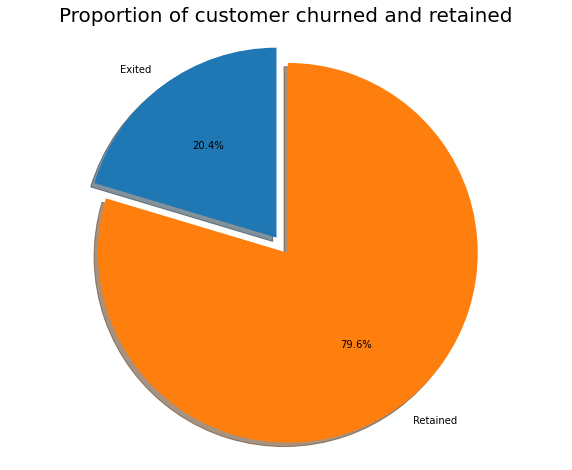

In [53]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

<AxesSubplot:xlabel='Exited', ylabel='count'>

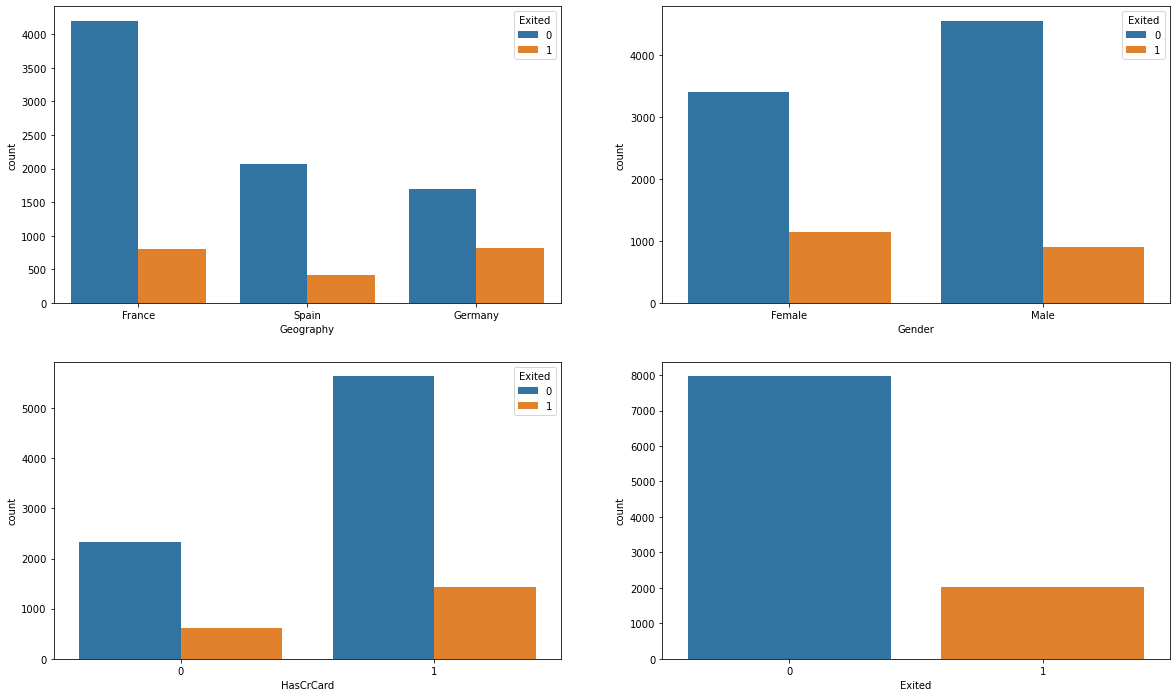

In [54]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x=df['Exited'])

<AxesSubplot:>

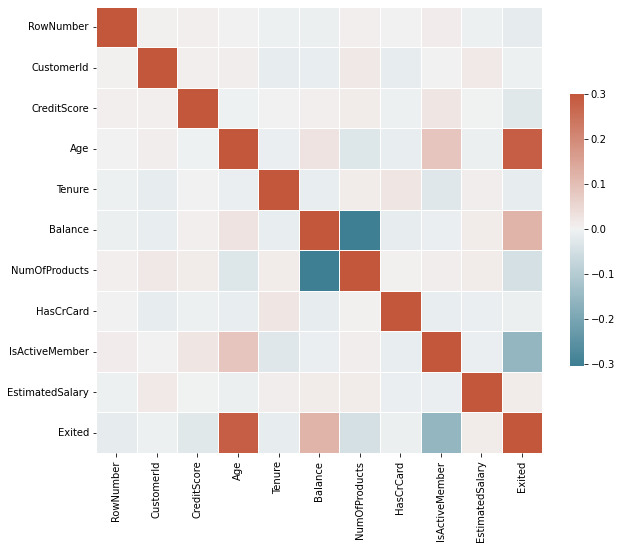

In [55]:
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, mask=None, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [56]:
data = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

dummy_feature_list = ['Gender','Geography'] 
for f in dummy_feature_list:
    dumm = make_dummy(data,f)
    data = pd.concat([data,dumm], axis=1)
data = data.drop(dummy_feature_list, axis=1)


In [57]:
X = data.drop(['Exited'],axis=1)
y = data.Exited 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

seed = 42
k = 1 
sm = SMOTE(sampling_strategy = 'minority', k_neighbors = k, random_state = seed)
res_X, res_y = sm.fit_resample(X, y)
res_X_train, res_X_test, res_y_train, res_y_test = train_test_split(res_X, res_y,test_size=0.2, random_state=42)

scaler = StandardScaler()
std_X = scaler.fit_transform(res_X)
std_X_train,std_X_test,std_y_train,std_y_test = train_test_split(std_X,res_y,test_size=0.2,random_state=42) 

X_train,X_test,y_train,y_test = std_X_train,std_X_test,std_y_train,std_y_test

In [61]:
from tensorflow.keras.models import Sequential
model=Sequential()
i = Input(shape=std_X_train[-1].shape)
x = Dense(512,  activation='relu')(i)
x = Dense(512,  activation='relu')(x)
x = Dense(256,  activation='relu')(x)
x = Dense(256,  activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)


model = Model(i, x)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=13)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_29 (Dense)            (None, 512)               7168      
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense_33 (Dense)            (None, 64)                16448     
                                                                 
 dense_34 (Dense)            (None, 32)                2080

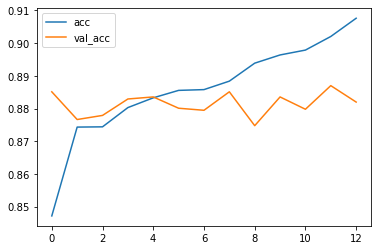

In [62]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

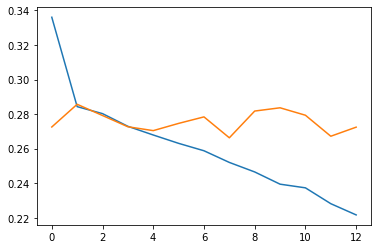

In [63]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

In [64]:
model.layers[1].get_weights()

[array([[ 0.16574293, -0.10412686,  0.02565014, ...,  0.04512744,
         -0.05925278, -0.13144077],
        [-0.06460653, -0.13576545,  0.01992024, ..., -0.02857116,
         -0.03763591,  0.03454191],
        [-0.08459544, -0.12026356, -0.03116599, ..., -0.23690277,
          0.00744914, -0.04042622],
        ...,
        [-0.00693448, -0.03410156, -0.04814154, ..., -0.13290033,
         -0.12827766, -0.07166757],
        [ 0.02010123, -0.16278584,  0.11522692, ...,  0.12540136,
          0.00614205,  0.02087142],
        [-0.06657324,  0.03772361, -0.03435418, ...,  0.09493341,
         -0.01460395,  0.0071352 ]], dtype=float32),
 array([-0.11865819, -0.14609939,  0.02992134, -0.07666621, -0.14699942,
        -0.00991394, -0.09200716, -0.1064456 ,  0.00117102, -0.13444723,
        -0.05608515, -0.10173666, -0.18346755, -0.06062585, -0.08432941,
        -0.12259587, -0.13813953, -0.13024706, -0.02102987, -0.18704863,
        -0.07713652, -0.15054148, -0.02911123, -0.10271249, -0.106

In [65]:
y_log=model.predict(X_test)

100/100 [==============================] - 1s 7ms/step


In [66]:
y_pred=np.where(y_log>0.5,1,0)

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n\n",cm)
print("\n")
ac=accuracy_score(y_test,y_pred)
print("Accuracy of the model :",ac)
print("\n")
print("classification report:\n",classification_report(y_test, y_pred))


Confusion matrix:

 [[1459  174]
 [ 202 1351]]


Accuracy of the model : 0.8819836785938481


classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      1633
           1       0.89      0.87      0.88      1553

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



In [75]:
i = Input(shape=std_X_train[-1].shape)
x = Dense(1024,  activation='relu')(i)
x = Dropout(0.2)(x)
x = Dense(512,  activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256,  activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256,  activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

import keras
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=13)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_45 (Dense)            (None, 1024)              14336     
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_47 (Dense)            (None, 256)               131328    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0   

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


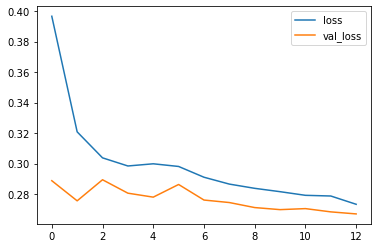

In [77]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

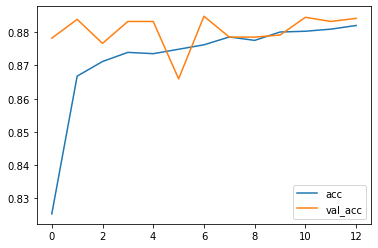

In [78]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [79]:
y_log=model.predict(X_test)

100/100 [==============================] - 1s 10ms/step


In [80]:
y_pred=np.where(y_log>0.5,1,0)

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n\n",cm)
print("\n")
ac=accuracy_score(y_test,y_pred)
print("Accuracy of the model :",ac)
print("\n")
print("classification report:\n",classification_report(y_test, y_pred))


Confusion matrix:

 [[1520  113]
 [ 256 1297]]


Accuracy of the model : 0.884180790960452


classification report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1633
           1       0.92      0.84      0.88      1553

    accuracy                           0.88      3186
   macro avg       0.89      0.88      0.88      3186
weighted avg       0.89      0.88      0.88      3186



In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
batch_size = 100
timesteps = 1

std_X_train_reshaped = std_X_train.reshape(std_X_train.shape[0], timesteps, std_X_train.shape[1])
std_X_test_reshaped = std_X_test.reshape(std_X_test.shape[0], timesteps, std_X_test.shape[1])

model = Sequential()

model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(timesteps, std_X_train.shape[1])))
model.add(LSTM(512, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
r = model.fit(std_X_train_reshaped, y_train, validation_data=(std_X_test_reshaped, y_test), epochs=20, batch_size=batch_size)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 1, 512)            1077248   
                                                                 
 lstm_85 (LSTM)              (None, 1, 512)            2099200   
                                                                 
 lstm_86 (LSTM)              (None, 1, 256)            787456    
                                                                 
 lstm_87 (LSTM)              (None, 1, 256)            525312    
                                                                 
 lstm_88 (LSTM)              (None, 1, 64)             82176     
                                                                 
 lstm_89 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_90 (LSTM)              (None, 16)              

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

timesteps = 1  
std_X_test_reshaped = std_X_test.reshape(std_X_test.shape[0], timesteps, std_X_test.shape[1])

probabilities = model.predict(std_X_test_reshaped)

predictions = (probabilities > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
print("\nConfusion matrix:\n\n",cm)
ac=accuracy_score(y_test,predictions)
report = classification_report(y_test, predictions)

print("\n\nclassification report:\n\n",report)


100/100 [==============================] - 2s 17ms/step

Confusion matrix:

 [[1494  139]
 [ 226 1327]]
classification report:

               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1633
           1       0.91      0.85      0.88      1553

    accuracy                           0.89      3186
   macro avg       0.89      0.88      0.89      3186
weighted avg       0.89      0.89      0.89      3186



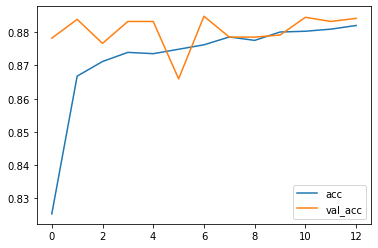

In [82]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

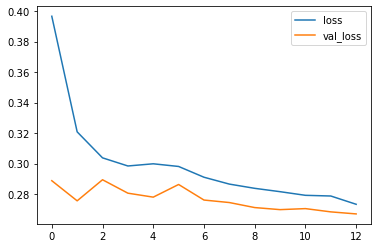

In [83]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

batch_size = 100

timesteps = 1
std_X_train_reshaped = std_X_train.reshape(std_X_train.shape[0], timesteps, std_X_train.shape[1])
std_X_test_reshaped = std_X_test.reshape(std_X_test.shape[0], timesteps, std_X_test.shape[1])

model = Sequential()

model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(timesteps, std_X_train.shape[1])))
model.add(Dropout(0.2)) 
model.add(LSTM(512, activation='relu', return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.4)) 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
r = model.fit(std_X_train_reshaped, y_train, validation_data=(std_X_test_reshaped, y_test), epochs=17, batch_size=batch_size)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 1, 512)            1077248   
                                                                 
 dropout_42 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_113 (LSTM)             (None, 1, 512)            2099200   
                                                                 
 dropout_43 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_114 (LSTM)             (None, 1, 256)            787456    
                                                                 
 dropout_44 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_115 (LSTM)             (None, 1, 256)          

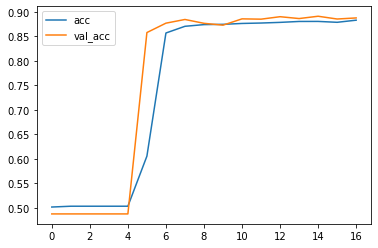

In [91]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

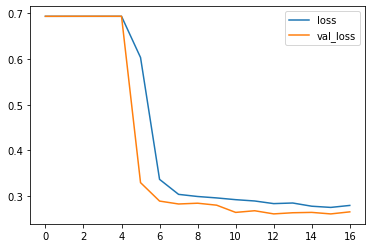

In [92]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [93]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

std_X_test_reshaped = std_X_test.reshape(std_X_test.shape[0], timesteps, std_X_test.shape[1])

probabilities = model.predict(std_X_test_reshaped)
predictions = (probabilities > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
print("\nConfusion matrix:\n\n",cm)
ac=accuracy_score(y_test,predictions)
report = classification_report(y_test, predictions)

print("\n\nclassification report:\n\n",report)


100/100 [==============================] - 3s 29ms/step

Confusion matrix:

 [[1515  118]
 [ 241 1312]]


classification report:

               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1633
           1       0.92      0.84      0.88      1553

    accuracy                           0.89      3186
   macro avg       0.89      0.89      0.89      3186
weighted avg       0.89      0.89      0.89      3186

